# Sentinel 3

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
from pathlib import Path
from io import StringIO
from functools import partial

import pandas as pd
import numpy as np
import plotly.express as px

# from WaterClass2.fitting import *

import matplotlib
import matplotlib.pyplot as plt

# from nbdev.showdoc import *
# from WaterClass2.Radiometry import *

# from WaterClass2.core import *

In [2]:
s3bands = [400, 412.5, 442, 490, 510, 560, 620, 665, 674, 681, 709, 754, 779, 865, 885, 1020]


def just_open_radiometry(path):
    df = pd.read_csv(path)    
    return df

def open_radiometry(path):
    old_names = [f'Oa{str(i).zfill(2)}_reflectance:float' for i in range(1, 22)]
    [old_names.remove(f'Oa{str(i).zfill(2)}_reflectance:float') for i in range(13,16)]
    [old_names.remove(f'Oa{str(i).zfill(2)}_reflectance:float') for i in range(19,21)]
    df = pd.read_csv(path).rename(columns={old_names[i]: s3bands[i] for i in range(16)})    
    return df


def normalize(df, bands, norm_band):
    df = df.copy()
    df[bands] = df[bands].to_numpy() - df[norm_band].to_numpy()[..., None]
    return df


def clip_negatives(df, bands, threshold=-0.1):
    return df.loc[~((df[bands] < -0.1).any(axis=1))]


def clean_radiometry(df, min_threshold=-0.1, norm_band=1020):

    if norm_band is not None:
        df = normalize(df, s3bands, 1020)

    df = clip_negatives(df, s3bands, -0.1)

    return df


def load_radiometries(path):

    csvs = [f for f in path.iterdir()]

    radiometries = {}
    min_pixels = 10

    for i, csv in enumerate(csvs):
        df = open_radiometry(csvs[i])
        if len(df) > 10:
            radiometries[csv.stem[16:24]] = df
            
    return radiometries

In [3]:
# file = Path(r'C:\Users\Mauricio Cordeiro\Downloads\14100000_manacapuru\S3A_OL_2_WFR____20161123T134634_20161123T134834_20171105T005133_0119_011_181______MR1_R_NT_002.csv')
# df = open_radiometry(file)
# plot_reflectances2(df, s3bands, color='T865:float', hover_vars=[], log_color=False)

## Load DataFrames in memory

In [4]:
base_path = Path(r'D:\S3\stations\14100000_manacapuru')

csvs = [f for f in base_path.iterdir()]

radiometries = {}
min_pixels = 10

for i, csv in enumerate(csvs):
    df = open_radiometry(csvs[i])
    if len(df) > 10:
        radiometries[csv.stem[16:24]]= df

## Calculate keys mean using RAW data

In [5]:
df = pd.DataFrame()

for radiometry in radiometries:
    df = df.append(radiometries[radiometry].mean().rename(radiometry))

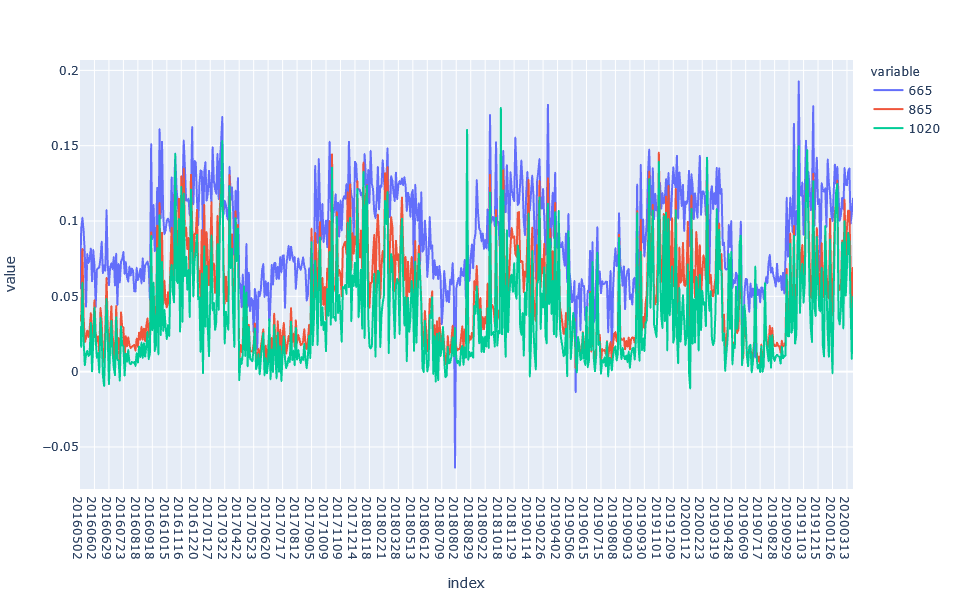

In [6]:
fig = px.line(df, y=[665, 865, 1020], height=600)
fig.show()

In [7]:
df[865].mean(),df[865].std()

(0.051597804402232106, 0.03439599452796976)

## Calc mean radiometry (getting 10% of pixels with abs(SWIR) closest to Zero)

In [8]:
df = pd.DataFrame()

for date, radiometry in radiometries.items():
    radiometry = clean_radiometry(radiometry, min_threshold=-0.1, norm_band=None) 
    radiometry['abs_1020'] = radiometry[1020].abs()
    radiometry = radiometry[radiometry['abs_1020']<radiometry['abs_1020'].quantile(q=0.20)]
    
    df = df.append(radiometry.mean().rename(date))

C:\Users\david\.conda\envs\git-prj\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



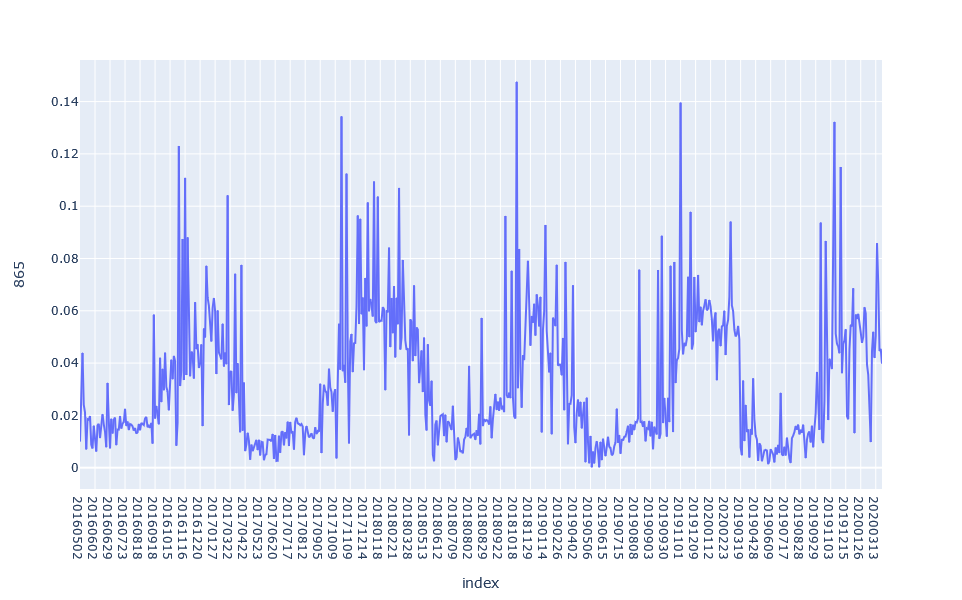

In [9]:
px.line(df, y=865, height=600,)

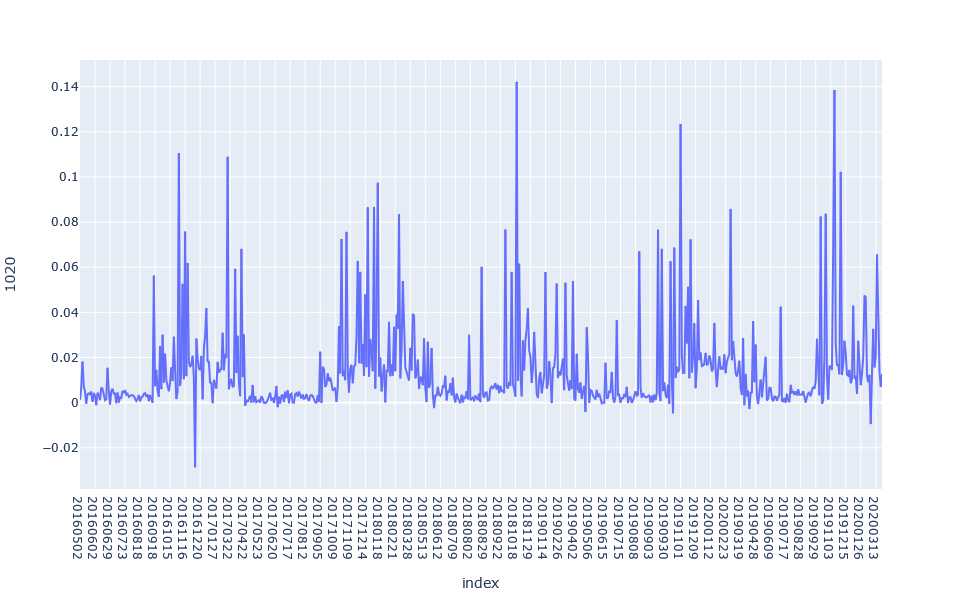

In [10]:
px.line(df, y=1020, height=600,)

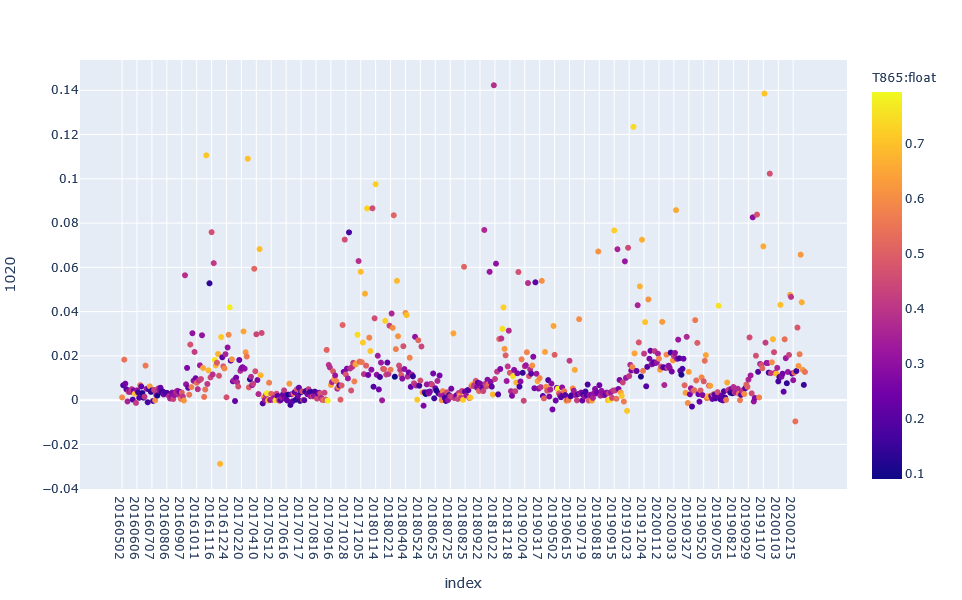

In [11]:
px.scatter(df, y=1020, height=600, color='T865:float')

In [12]:
df[865].mean(),df[865].std()

(0.03202786513515965, 0.025189817207206044)

## Calc mean radiometry (Normalized in 1020)

In [13]:
df = pd.DataFrame()

for date, radiometry in radiometries.items():
    radiometry = clean_radiometry(radiometry, min_threshold=-0.1, norm_band=1020) 
    df = df.append(radiometry.mean().rename(date))

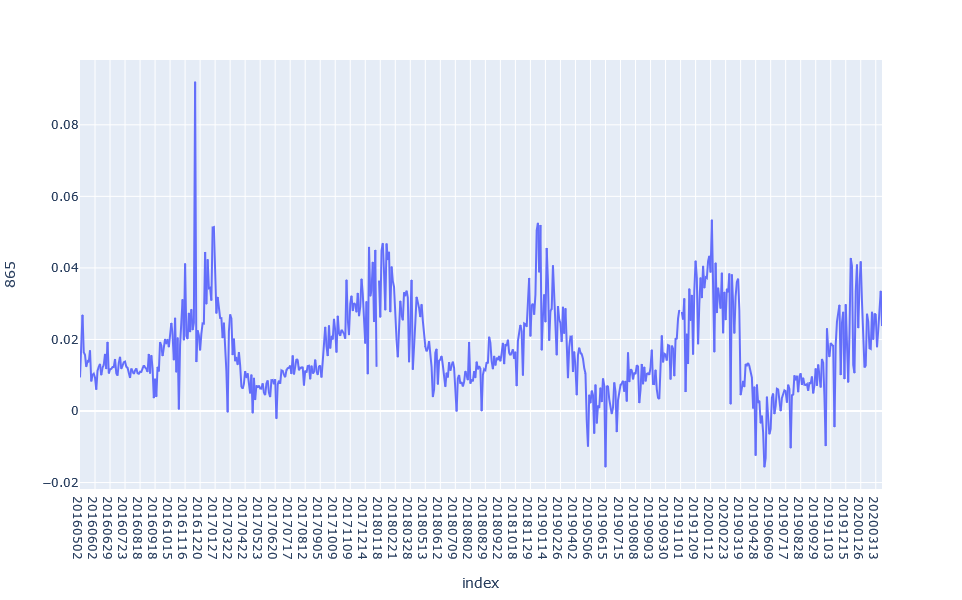

In [14]:
px.line(df, y=865, height=600,)

In [15]:
def calc_nd_index(df, band1, band2, column_name='nd_index'):
    idx = (df[band1]-df[band2])/(df[band1]+df[band2])
    df[column_name] = idx
    
def db_scan(df, bands, column_name='cluster', eps=0.1, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df[bands])
    df[column_name] = clustering.labels_
    

## Calc using DBSCAN Clusters to choose the right ensemble

In [16]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [17]:
radiometries = load_radiometries(Path(r'D:\processing\linux\14100000_manacapuru_v15'))

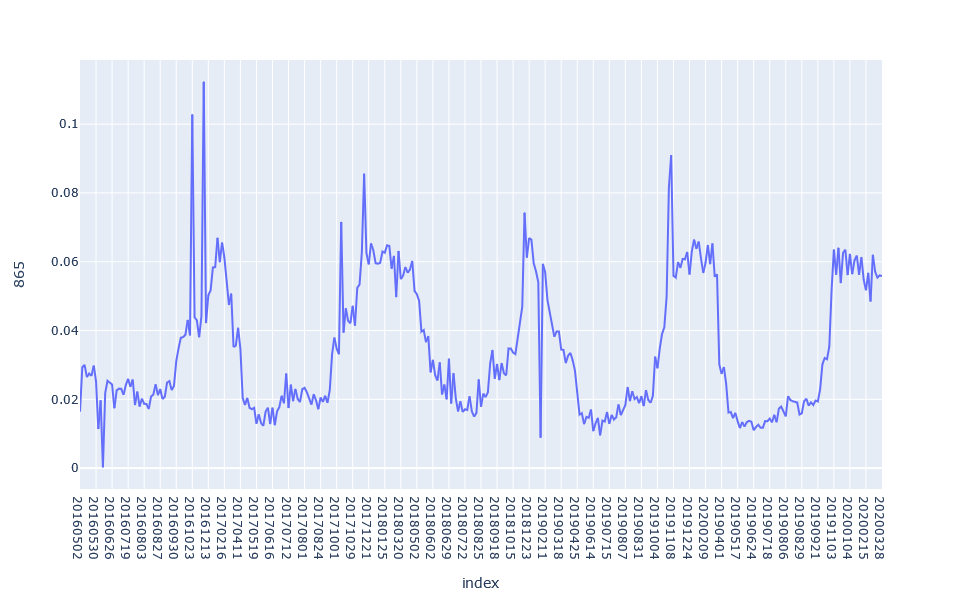

In [36]:
pd.options.mode.chained_assignment = None  # default='warn'

def create_time_series_cluster(radiometries, eps=0.01, min_samples=5):
    df = pd.DataFrame()

    for date, radiometry in radiometries.items():

        # clean some outliars  using the indices
        calc_nd_index(radiometry, 560, 1020, column_name='mndwi')  # Green / SWIR
        calc_nd_index(radiometry, 560, 865, column_name='ndwi')  # Green / IR

        valid_mndwi = (radiometry['mndwi'] > -0.99) & (radiometry['mndwi'] < 0.99)
        valid_ndwi = (radiometry['ndwi'] > -0.99) & (radiometry['ndwi'] < 0.99)

        radiometry = radiometry[valid_mndwi & valid_ndwi]

        if len(radiometry) < min_samples:
            continue 
        db_scan(radiometry, [865, 1020], eps=eps, min_samples=min_samples)
        clusters = radiometry.groupby(by='cluster').mean()

        # drop the noise
        clusters.drop(-1, inplace=True, errors='ignore')

        # if there is at least 1 valid cluster
        if len(clusters) > 0:
            df = df.append(clusters[clusters[1020] == clusters[1020].min()].iloc[0].rename(date))

    return df

df = create_time_series_cluster(radiometries)
px.line(df, y=865, height=600,)

# Fonte Boa

In [19]:
# radiometries = load_radiometries(Path(r'C:\Users\Mauricio Cordeiro\Downloads\v15\12350000_fonte_boa_v15'))
# df = create_time_series_cluster(radiometries)
# px.line(df, y=865, height=600,)

# Tefe

In [20]:
# radiometries = load_radiometries(Path(r'C:\Users\Mauricio Cordeiro\Downloads\v15\12900001_tefe_v15'))
# df = create_time_series_cluster(radiometries)
# px.line(df, y=865, height=600,)

# Coari

In [21]:
# radiometries = load_radiometries(Path(r'C:\Users\Mauricio Cordeiro\Downloads\v15\13100090_coari_v15'))
# df = create_time_series_cluster(radiometries)
# px.line(df, y=865, height=600,)

# Borba Madeira

In [22]:
# radiometries = load_radiometries(Path(r'C:\Users\Mauricio Cordeiro\Downloads\v15\15860000_borba_madeira_v15'))
# df = create_time_series_cluster(radiometries)
# px.line(df, y=865, height=600,)

# Obidos MNC

In [23]:
# radiometries = load_radiometries(Path(r'C:\Users\Mauricio Cordeiro\Downloads\v15\17050001_obidos_v15_mnc'))
# df = create_time_series_cluster(radiometries)
# px.line(df, y=865, height=600,)

# Obidos b

In [24]:
# radiometries = load_radiometries(Path(r'C:\Users\Mauricio Cordeiro\Downloads\v15\17050001_obidos_v15b'))
# df = create_time_series_cluster(radiometries)
# px.line(df, y=865, height=600,)

# Anavilhanas

In [25]:
# radiometries = load_radiometries(Path(r'C:\Users\Mauricio Cordeiro\Downloads\v15\AN1_v15'))
# df = create_time_series_cluster(radiometries)
# px.line(df, y=865, height=600,)

# Branco

In [26]:
# radiometries = load_radiometries(Path(r'C:\Users\Mauricio Cordeiro\Downloads\v15\BCO_v15'))
# df = create_time_series_cluster(radiometries)
# px.line(df, y=865, height=600,)

# Test AREA

In [29]:
# df = list(radiometries.values())[6]
df = radiometries['20161123']
# clean some outliars  using the indices
calc_nd_index(df, 560, 1020, column_name='mndwi')
calc_nd_index(df, 560, 865, column_name='ndwi')

valid_mndwi = (df['mndwi'] > -0.95) & (df['mndwi'] < 0.95)
valid_ndwi = (df['ndwi'] > -0.95) & (df['ndwi'] < 0.95)

df = df[valid_mndwi & valid_ndwi]


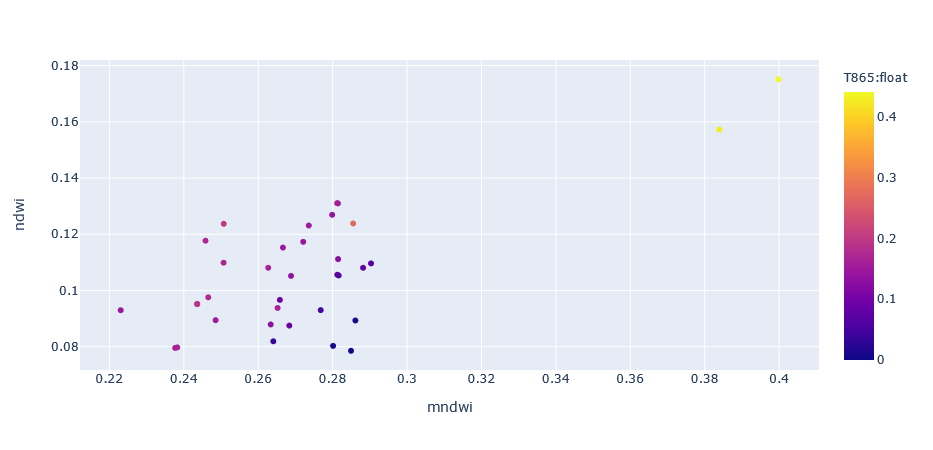

In [30]:
px.scatter(df, x='mndwi', y='ndwi', color='T865:float')

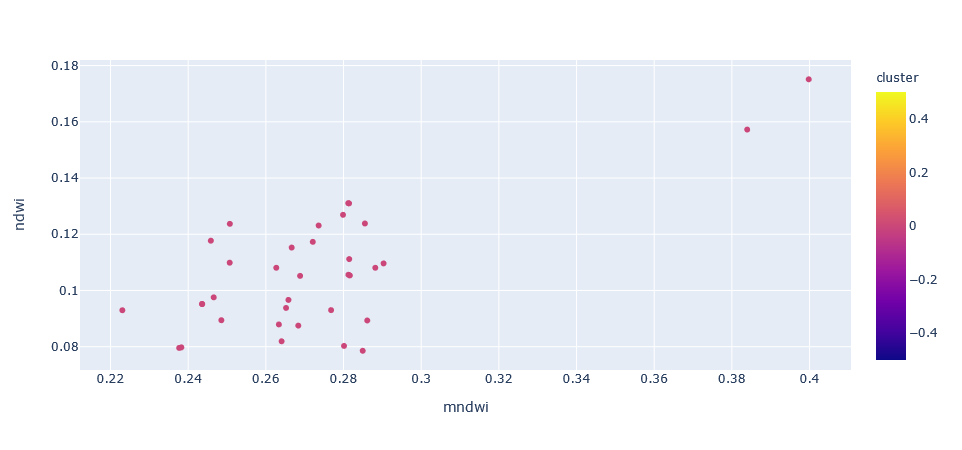

In [31]:
db_scan(df, ['mndwi', 'ndwi'], eps=0.5)
px.scatter(df, x='mndwi', y='ndwi', color='cluster')

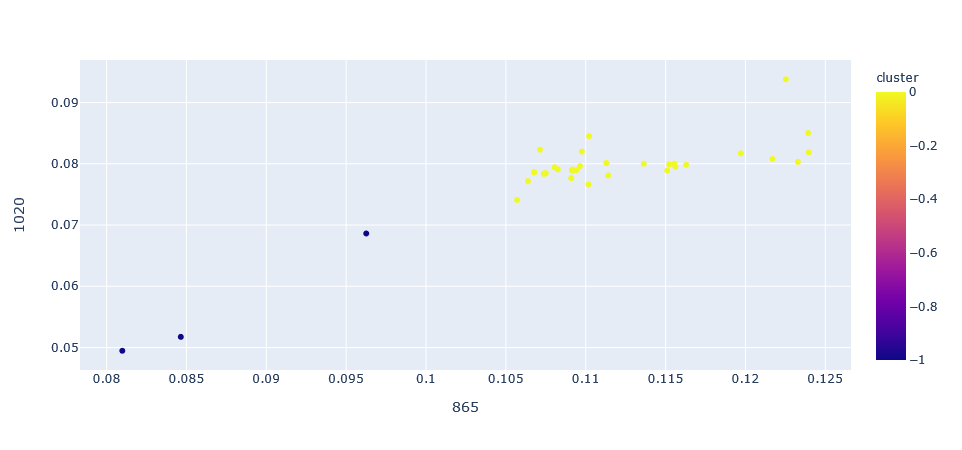

In [32]:
db_scan(df, [865, 1020], eps=0.01)
px.scatter(df, x=865, y=1020, color='cluster')

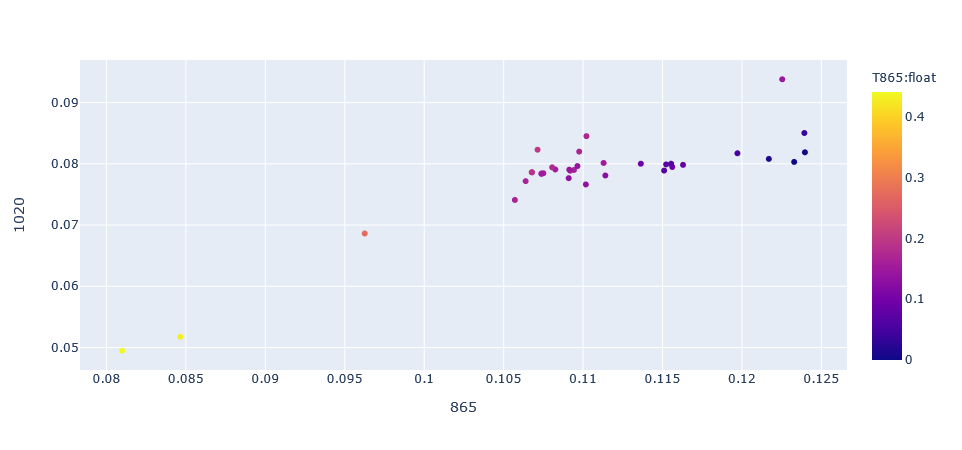

In [33]:
px.scatter(df, x=865, y=1020, color='T865:float')

In [42]:
df[s3bands]

400     412.5       442       490       510       560  \
20160502  0.009124  0.008529  0.012405  0.019537  0.024522  0.039941   
20160506  0.038581  0.036486  0.039108  0.046438  0.052847  0.073584   
20160510  0.038186  0.035500  0.037815  0.045150  0.051922  0.073033   
20160514  0.013317  0.013854  0.021746  0.034047  0.041966  0.064777   
20160518  0.009355  0.010537  0.019669  0.032830  0.041030  0.064955   
...            ...       ...       ...       ...       ...       ...   
20200313  0.006526  0.014141  0.027332  0.044098  0.053352  0.078868   
20200321  0.017423  0.023011  0.035913  0.055508  0.068775  0.103186   
20200324 -0.002117  0.004370  0.020288  0.041377  0.052709  0.086842   
20200325 -0.023360 -0.013807  0.005717  0.032056  0.047377  0.085117   
20200328 -0.011678 -0.005706  0.010298  0.032960  0.045145  0.083348   

               620       665       674       681       709       754  \
20160502  0.050062  0.053882  0.054834  0.055231  0.049974  0.027054   
20160506  0.090033  0.096875  0.098332  0.099125  0.090490  0.045708   
20160510  0.089142  0.095946  0.097367  0.098208  0.089976  0.047014   
20160514  0.082091  0.089271  0.090815  0.091796  0.083611  0.041500   
20160518  0.081826  0.088448  0.090149  0.091160  0.083228  0.043866   
...            ...       ...       ...       ...       ...       ...   
20200313  0.095771  0.100946  0.102144  0.102476  0.101265  0.082757   
20200321  0.129870  0.140504  0.141745  0.142750  0.143546  0.089008   
20200324  0.112212  0.121110  0.122895  0.124244  0.121568  0.077202   
20200325  0.113299  0.125395  0.126923  0.128145  0.130936  0.084279   
20200328  0.111688  0.122049  0.124174  0.125500  0.121610  0.080919   

               779       865       885      1020  
20160502  0.029158  0.016413  0.013544  0.006042  
20160506  0.048633  0.029324  0.025374  0.009594  
20160510  0.049487  0.030050  0.026079  0.012185  
20160514  0.044299  0.026440  0.022731  0.010309  
20160518  0.046003  0.027505  0.023641  0.012776  
...            ...       ...       ...       ...  
20200313  0.087074  0.062069  0.055121  0.028316  
20200321  0.084999  0.057098  0.050018  0.024400  
20200324  0.080657  0.055388  0.049376  0.020180  
20200325  0.082804  0.056044  0.049205  0.019505  
20200328  0.081872  0.055827  0.049258  0.024097  

[351 rows x 16 columns]

In [51]:
pca = PCA()

In [52]:
arrs_dfs3 = df[s3bands].to_numpy()

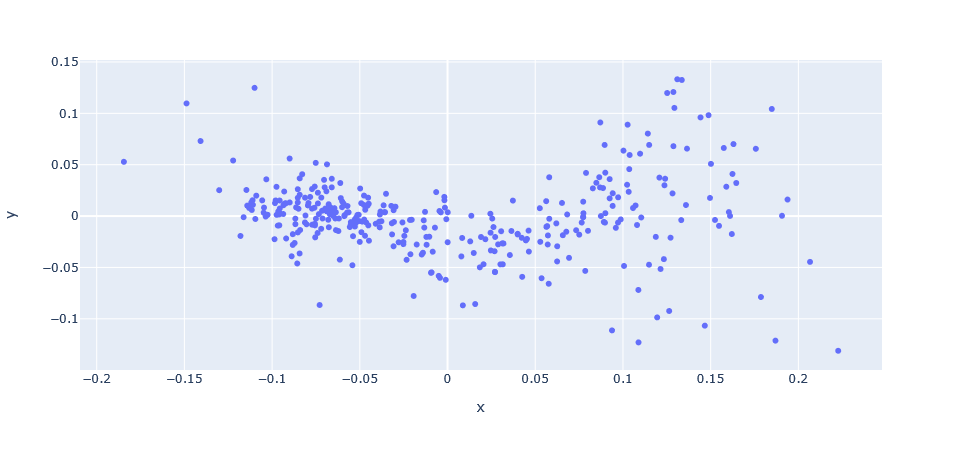

In [54]:
components = pca.fit_transform(arrs_dfs3)
px.scatter(x=components[:, 0], y=components[:, 1])

In [55]:
pca.components_.shape

(16, 16)

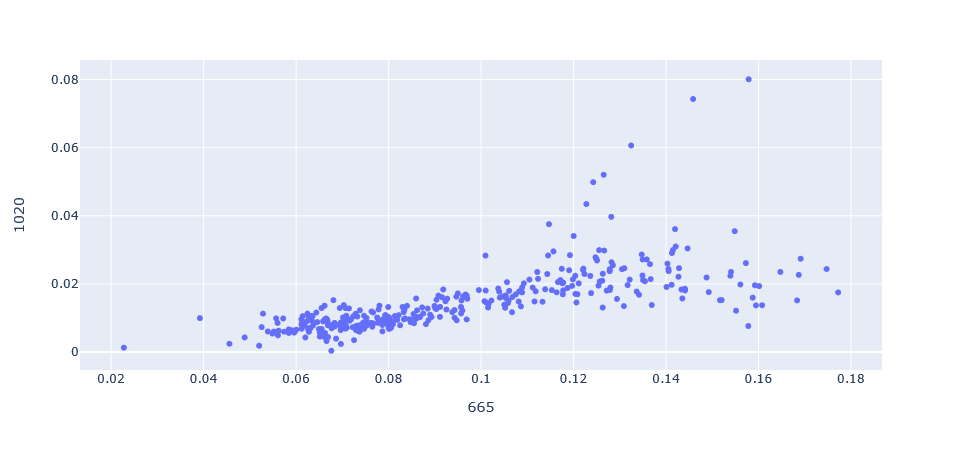

In [56]:
px.scatter(df, 665, 1020)

In [57]:
df = pd.DataFrame()

for date, radiometry in radiometries.items():
    radiometry = clean_radiometry(radiometry, min_threshold=-0.1, norm_band=1020) 
    df = df.append(radiometry.mean().rename(date))

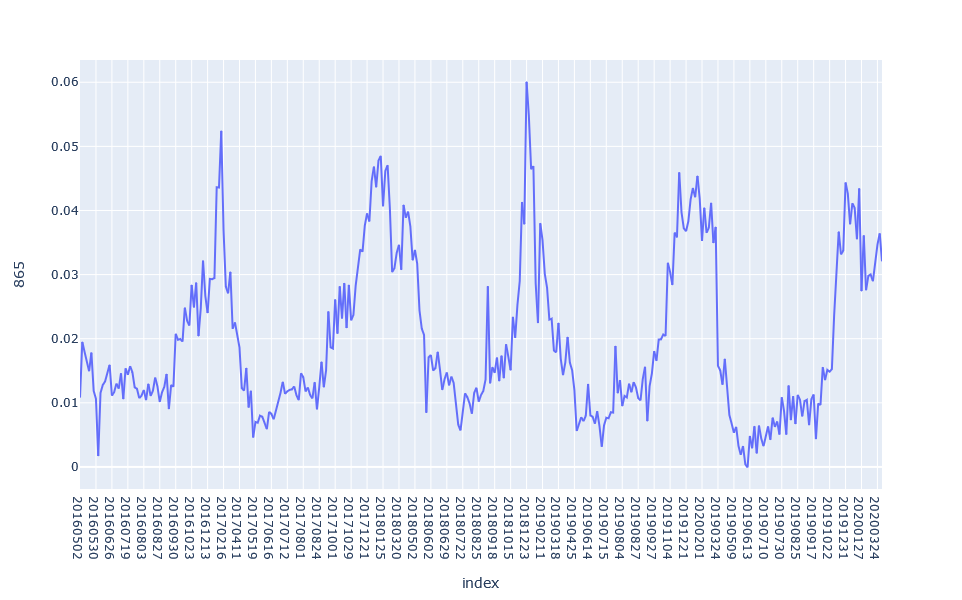

In [58]:
px.line(df, y=865, height=600,)

## Calc mean radiometry (getting 10% of pixels with abs(SWIR) closest to Zero)

In [59]:
df = pd.DataFrame()

for date, radiometry in radiometries.items():
    radiometry = clean_radiometry(radiometry, min_threshold=-0.1, norm_band=None) 
    radiometry['abs_1020'] = radiometry[1020].abs()

    radiometry = radiometry[radiometry['abs_1020']<radiometry['abs_1020'].quantile(q=0.05)]
    
    df = df.append(radiometry.mean().rename(date))

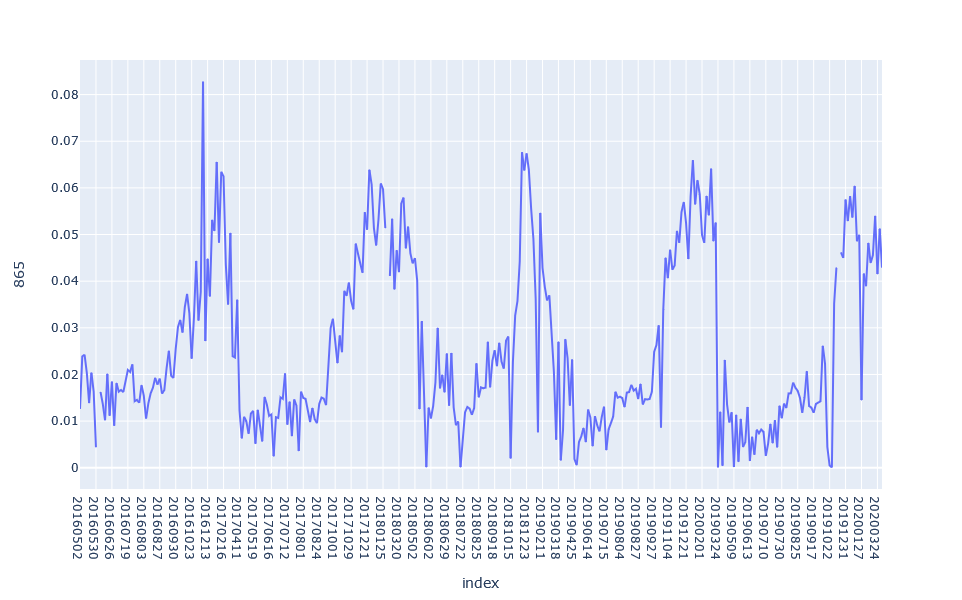

In [60]:
px.line(df, y=865, height=600,)

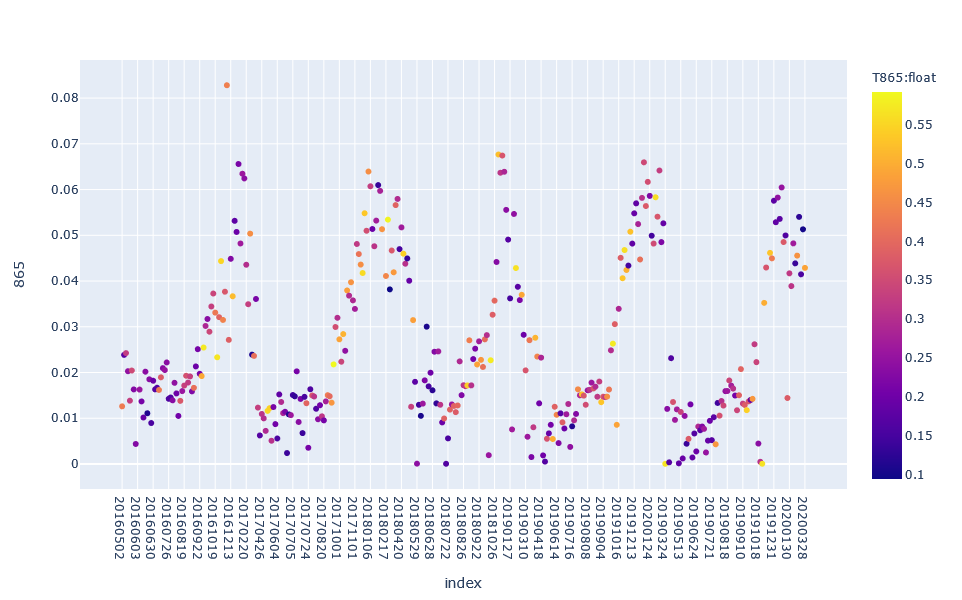

In [61]:
px.scatter(df, y=865, height=600, color='T865:float')